<h1 align=center face="verdana" style="color:#6699FF";font-family:verdana>Utilization of Machine Learning to Predict Titanic Passenger Fate</h1>
<h3 align=center>Meera Lakhavani</h3>
<h4 align=center>9/25/2015</h4>

This Python code follows the data science workflow and implements **logistic regression**, **random forests**,  **support vector machines**, and **naive bayes** from the **scikit-learn**, **statsmodels**, **numpy**, and **pandas** packages to predict survival of passengers onboard the Titanic.

<h2 style="color:#6699FF">1) Read Data</h2>

We are given a full set of data (<font face="courier">titanic_full.csv</font>) with information about Titanic passengers and their survival outcome. I utilized pandas to read the .csv file because it allows me to import the file easily and clean it effectively.

In [1]:
import pandas as pd
titanic_full = pd.read_csv("titanic_full.csv")

I chose to print the first few rows of <font face="courier">titanic_full</font> to insure that it was read properly. This also allows me to glance at possible gaps in the data.

In [2]:
titanic_full.head(5)

,survived,name,sex,age,sibsp,parch,pclass,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,1,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,1,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,1,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,1,113781,151.5500,C22 C26,S,NaN,135,"Montreal, PQ / Chesterville, ON"
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,1,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


<h2 style="color:#6699FF"> 2) Explore Data</h2>

Here, I begin an exploration looking for gaps in the data. Specifically I will search for missing and NaN values. I will also start making hypotheses on which factors could influence survival. I will consider the dismissal of variables that are unlikely to have an impact.

In [3]:
# Search for unique values in categorical variable: embarked
# Use this as a tool to seek NaN values
print(titanic_full["embarked"].unique())

['S' 'C' nan 'Q']


A 'nan' value is initially seen when searching for unique categorical variables in the "embarked" column. In order to have data that can be processed by scikit-learn algorithms, we must fill in these missing values.

One approach is to replace missing values with the most commonly occuring value. To find this value, I will use pandas <font face="courier">.value_counts()</font>.

In [4]:
embarked_counts = titanic_full["embarked"].value_counts()
embarked_counts

S    914
C    270
Q    123
dtype: int64

The <font face="courier">.value_counts()</font> command shows us that the vast majority of embarkments were from 'S'. With some confidence, we can fill in NaN values with 'S'.

A quick way to continue our exploration is to use <font face="courier">.isnull().any()</font> to return columns that contain missing values.

In [5]:
# Return booleans regarding whether the column contains null values
titanic_full.isnull().any()

survived     False
name         False
sex          False
age           True
sibsp        False
parch        False
pclass       False
ticket       False
fare          True
cabin         True
embarked      True
boat          True
body          True
home.dest     True
dtype: bool

Our takeaways from this exploration have given us more clarity on what needs to be cleaned. Specifically, values must be filled in for "embarked", "fare", and "age".

<h2 style="color:#6699FF"> 3) Clean Data</h2>

My approach for cleaning the data is as follows:

**1. Fill in missing values**
* Replace missing age values with median age
* Replace missing fare values with median fares
* Replace missing categorical values from embarked column with most common occurence (S)

**2. Ensure all values are numeric** so that scikit-learn can process and train on the data frame
* Binary assignments for gender are suitable (1 and 0)
* Embarked codes can be assigned dummy numeric variables

**3. Use given information to create useful variables**
I decided to create categrorical variables from the name column for titles (Miss., Sir, Captain, etc.) to see if it has an impact on survival.

**4. Determine which columns should be ignored as predictors**
* Remove columns that have obvious and direct impact on survival (survived, body, boat)
* Remove columns with little or no statistical significance (ticket number, cabin, home destination)
    * If desired, we can analyze these factors further later (ex. socioeconomic status of destination, cabin proximity to lifeboats)


<u>This leaves us with **fare**, **embarked**, **age**, **sex**, **sibsp**, **pclass**, **parch**, and **title** as predictor varibles.</u>

In [6]:
# Replace missing age values with median age
titanic_full["age"] = titanic_full["age"].fillna(titanic_full["age"].median())

#replace missing fares with median
titanic_full["fare"] = titanic_full["fare"].fillna(titanic_full["fare"].median())

In [7]:
# Replace missing values with code S
titanic_full["embarked"] = titanic_full["embarked"].fillna("S")

# Create dummy variables for embarked column -- three new columns with binary responses to category
# embarked_dummies.columns = ['embarked s', 'embarked c', 'embarked q']
embarked_dummies = pd.get_dummies(titanic_full['embarked'])

# Confirm that the correct columns were created
print embarked_dummies.head(3)

# Combine data set with new variable columns in new data frame
titanic_full_new = pd.concat([titanic_full, embarked_dummies], axis=1); titanic_full_new
titanic_full_new = titanic_full_new.drop('embarked', 1)

#Confirm that new data frame is correct
print titanic_full_new.head(3)

   C  Q  S
0  0  0  1
1  0  0  1
2  0  0  1
   survived                            name     sex      age  sibsp  parch  \
0         1   Allen, Miss. Elisabeth Walton  female  29.0000      0      0   
1         1  Allison, Master. Hudson Trevor    male   0.9167      1      2   
2         0    Allison, Miss. Helen Loraine  female   2.0000      1      2   

   pclass  ticket      fare    cabin boat  body  \
0       1   24160  211.3375       B5    2   NaN   
1       1  113781  151.5500  C22 C26   11   NaN   
2       1  113781  151.5500  C22 C26  NaN   NaN   

                         home.dest  C  Q  S  
0                     St Louis, MO  0  0  1  
1  Montreal, PQ / Chesterville, ON  0  0  1  
2  Montreal, PQ / Chesterville, ON  0  0  1  


In [8]:
# Replace all the occurences of male with the number 0, and female with 1
titanic_full_new.loc[titanic_full["sex"] == "male", "sex"] = 0
titanic_full_new.loc[titanic_full["sex"] == "female", "sex"] = 1

The code below was directly inspired by: https://www.dataquest.io/mission/75/improving-your-submission/

In [9]:
# Create titles column from current name column

import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titles = titanic_full_new['name'].apply(get_title)

titles.head(3)

titanic_full_new = pd.concat([titanic_full_new, titles], axis=1)

#titanic_full_new = pd.concat([titanic_full_new, titles], axis=1); titanic_full_new

# Print how often each title occurs
print(pd.value_counts(titles))

titanic_full_new.head(3)

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Mlle          2
Ms            2
Don           1
Capt          1
Lady          1
Sir           1
Countess      1
Jonkheer      1
Dona          1
Mme           1
dtype: int64


,survived,name,sex,age,sibsp,parch,pclass,ticket,fare,cabin,boat,body,home.dest,C,Q,S,name
0,1,"Allen, Miss. Elisabeth Walton",1,29.0000,0,0,1,24160,211.3375,B5,2,NaN,"St Louis, MO",0,0,1,Miss
1,1,"Allison, Master. Hudson Trevor",0,0.9167,1,2,1,113781,151.5500,C22 C26,11,NaN,"Montreal, PQ / Chesterville, ON",0,0,1,Master
2,0,"Allison, Miss. Helen Loraine",1,2.0000,1,2,1,113781,151.5500,C22 C26,NaN,NaN,"Montreal, PQ / Chesterville, ON",0,0,1,Miss


In [10]:
# Rename duplicated 'name' column to 'titles'
# Perform column name replacement more elegantly if time

titanic_full_new.columns = ['survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'pclass', 'ticket', 'fare', 'cabin', 'boat', 'body', 'home.dest', 'C', 'Q', 'S', 'title']
titanic_full_new.head(3)

,survived,name,sex,age,sibsp,parch,pclass,ticket,fare,cabin,boat,body,home.dest,C,Q,S,title
0,1,"Allen, Miss. Elisabeth Walton",1,29.0000,0,0,1,24160,211.3375,B5,2,NaN,"St Louis, MO",0,0,1,Miss
1,1,"Allison, Master. Hudson Trevor",0,0.9167,1,2,1,113781,151.5500,C22 C26,11,NaN,"Montreal, PQ / Chesterville, ON",0,0,1,Master
2,0,"Allison, Miss. Helen Loraine",1,2.0000,1,2,1,113781,151.5500,C22 C26,NaN,NaN,"Montreal, PQ / Chesterville, ON",0,0,1,Miss


In [11]:
# Remove unnecessary columns from new data frame

for i in ['name', 'ticket', 'cabin', 'boat', 'body', 'home.dest']:
    titanic_full_new = titanic_full_new.drop(i, 1)

titanic_full_new.head(2)

,survived,sex,age,sibsp,parch,pclass,fare,C,Q,S,title
0,1,1,29.0000,0,0,1,211.3375,0,0,1,Miss
1,1,0,0.9167,1,2,1,151.5500,0,0,1,Master


In [12]:
# Turn 'title' into categorical dummy variables
# If there are less than two occurances of the title, assign it 'Mr'

#titles.head(3)

#title_occurance = (pd.value_counts(titles))

#print title_occurance

titles_irrelevant = ['Major', 'Mlle', 'Ms', 'Don', 'Capt', 'Lady', 'Sir', 'Countess', 'Jonkheer', 'Dona', 'Mme']

for i in titles_irrelevant:
#    titanic_full_new["title"].replace([i], ["Mr"])
    
    titanic_full_new['title'] = titanic_full_new['title'].replace({i: 'Mr'})
                             
titanic_full_new.head(3)


,survived,sex,age,sibsp,parch,pclass,fare,C,Q,S,title
0,1,1,29.0000,0,0,1,211.3375,0,0,1,Miss
1,1,0,0.9167,1,2,1,151.5500,0,0,1,Master
2,0,1,2.0000,1,2,1,151.5500,0,0,1,Miss


In [13]:
print(titanic_full_new["title"].unique())

['Miss' 'Master' 'Mr' 'Mrs' 'Col' 'Dr' 'Rev']


In [14]:
# Assign dummy variables for title categories

# Create dummy variables for title column -- seven new columns with binary responses to categorical title
# embarked_dummies.columns = ['embarked s', 'embarked c', 'embarked q']
title_dummies = pd.get_dummies(titanic_full_new["title"])

# Confirm that the correct columns were created
print title_dummies.head(3)

# Combine data set with new variable columns in new data frame
titanic_full_new = pd.concat([titanic_full_new, title_dummies], axis=1); titanic_full_new
titanic_full_new.head(4)

   Col  Dr  Master  Miss  Mr  Mrs  Rev
0    0   0       0     1   0    0    0
1    0   0       1     0   0    0    0
2    0   0       0     1   0    0    0


,survived,sex,age,sibsp,parch,pclass,fare,C,Q,S,title,Col,Dr,Master,Miss,Mr,Mrs,Rev
0,1,1,29.0000,0,0,1,211.3375,0,0,1,Miss,0,0,0,1,0,0,0
1,1,0,0.9167,1,2,1,151.5500,0,0,1,Master,0,0,1,0,0,0,0
2,0,1,2.0000,1,2,1,151.5500,0,0,1,Miss,0,0,0,1,0,0,0
3,0,0,30.0000,1,2,1,151.5500,0,0,1,Mr,0,0,0,0,1,0,0


In [15]:
titanic_full_new = titanic_full_new.drop("title", 1)

#Confirm that new data frame is correct
titanic_full_new.head(3)

,survived,sex,age,sibsp,parch,pclass,fare,C,Q,S,Col,Dr,Master,Miss,Mr,Mrs,Rev
0,1,1,29.0000,0,0,1,211.3375,0,0,1,0,0,0,1,0,0,0
1,1,0,0.9167,1,2,1,151.5500,0,0,1,0,0,1,0,0,0,0
2,0,1,2.0000,1,2,1,151.5500,0,0,1,0,0,0,1,0,0,0


In [16]:
# Check to make sure there are now no null values
titanic_full_new.isnull().any()

survived    False
sex         False
age         False
sibsp       False
parch       False
pclass      False
fare        False
C           False
Q           False
S           False
Col         False
Dr          False
Master      False
Miss        False
Mr          False
Mrs         False
Rev         False
dtype: bool

<h2 style="color:#6699FF"> 4) Visualize Data</h2>

Here we can utilize plotting tools such as **matplotlib**, **statsmodels**, and **seaborn** to continue exploring the data and creating hypotheses on which variables will most influence survival.

In [17]:
# Import modules
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
import seaborn

In [18]:
# Show plots in the notebook
%matplotlib inline

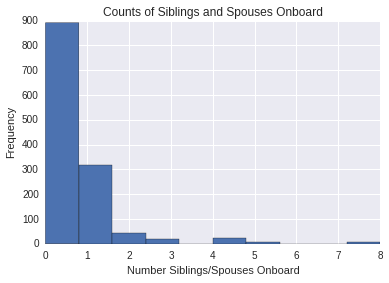

In [19]:
# Histogram of sibsp
# Remove this because it is boring
titanic_full_new.sibsp.hist()
plt.title('Counts of Siblings and Spouses Onboard')
plt.xlabel('Number Siblings/Spouses Onboard')
plt.ylabel('Frequency')

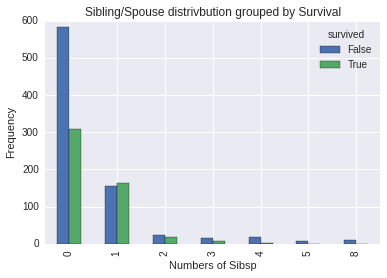

In [20]:
# barplot of sibsp rating grouped by survival (1 or 2)
pd.crosstab(titanic_full.sibsp, titanic_full.survived.astype(bool)).plot(kind='bar')
plt.title('Sibling/Spouse distrivbution grouped by Survival')
plt.xlabel('Numbers of Sibsp')
plt.ylabel('Frequency')

Survival Probability Based on Class and Gender


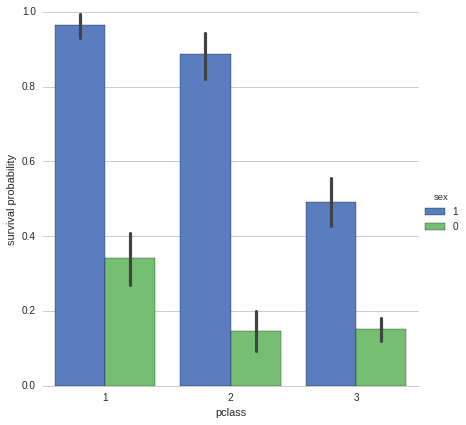

In [21]:
import seaborn as sns
sns.set(style="whitegrid")

# sns.factorplot.title('Survival Probability Based on Class and Gender')
print "Survival Probability Based on Class and Gender"

# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="pclass", y="survived", hue="sex", data=titanic_full_new, size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

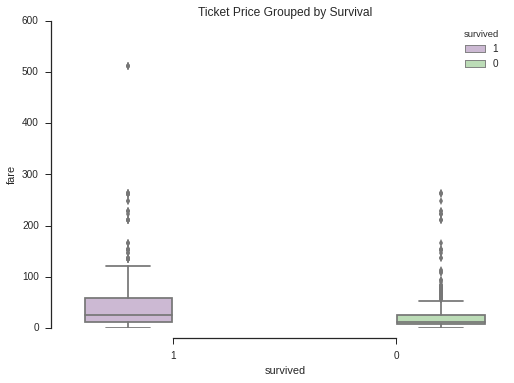

In [22]:
# Boxplot of ticket price with respect to survival

import seaborn as sns
sns.set(style="ticks")

sns.plt.title('Ticket Price Grouped by Survival')

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="survived", y="fare", hue="survived", data=titanic_full_new, palette="PRGn")
sns.despine(offset=10, trim=True)

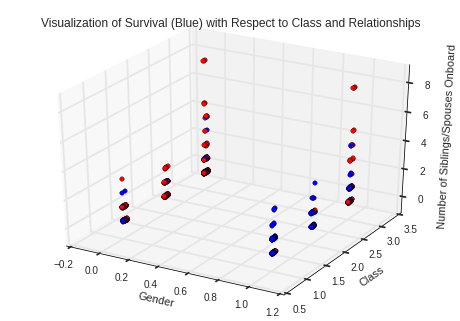

In [23]:
# 3D Visualization

# from: https://www.kaggle.com/hekkon/titanic/testing/files

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cross_validation import train_test_split
titanic_train, titanic_test = train_test_split(titanic_full_new, test_size = 0.3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for n,point in titanic_train.iterrows():
    gender = point['sex']
    pclass = point['pclass'] + np.random.rand()/10
    surv = point['survived'] 
    third_feature = point['sibsp'] + np.random.rand()/10
    color = 'blue' if surv else 'red'

    ax.scatter(gender, pclass, third_feature, c=color)

plt.title('Visualization of Survival (Blue) with Respect to Class and Relationships')
ax.set_xlabel('Gender')
ax.set_ylabel('Class')
ax.set_zlabel('Number of Siblings/Spouses Onboard')

plt.show()

plt.savefig('viz.png')

<h2 style="color:#6699FF"> 5) Build Models</h2>

Now, onto the juicy stuff! We will train multiple models based on our (predicted to be) important variables and their effect on survival.

1. Start by splitting our full test set into a training (70%) and test set (30%)
2. Implement **logistic regression**
    <br>&nbsp;&nbsp;&nbsp;&nbsp;An equation of close fit taking into account predictive variables and binary outcome</br>
3. **Random forests**<br>&nbsp;&nbsp;&nbsp;&nbsp;Many decision trees to trace occurance of paths based on likely splits</br> 
4. Support vector machines
5. Naive bayes


In [24]:
# Split full data set for training and testing purposes

from sklearn.cross_validation import train_test_split

titanic_train, titanic_test = train_test_split(titanic_full_new, test_size = 0.3)

<u><h4 style="color:#6699FF">Logistic Regression</h4></u>

In [25]:
# Prepare data for logistic regression

from patsy import dmatrices

y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

print x.columns

Index([u'Intercept', u'sex[T.1]', u'age', u'sibsp', u'parch', u'pclass',
       u'fare', u'C', u'Q', u'S', u'Col', u'Dr', u'Master', u'Miss', u'Mr',
       u'Mrs', u'Rev'],
      dtype='object')


In [26]:
import numpy as np

# Flatten y into a 1-D array
y = np.ravel(y)

# Initiate a logistic regression model, and fit with X and y
LRmodel = LogisticRegression()
LRmodel = LRmodel.fit(x, y)

# Check the accuracy on the training set
LRmodel.score(x_test, y_test['survived'])

# add .values to end of x and y variables if this stops running

0.77099236641221369

In [27]:
print titanic_full_new.columns

Index([u'survived', u'sex', u'age', u'sibsp', u'parch', u'pclass', u'fare',
       u'C', u'Q', u'S', u'Col', u'Dr', u'Master', u'Miss', u'Mr', u'Mrs',
       u'Rev'],
      dtype='object')


In [28]:
# Logistic regression using statsmodels

import statsmodels.api as sm
import numpy as np

a = titanic_full_new['survived']
b = titanic_full_new.drop('survived', axis=1).astype(int)

a1 = np.asarray(a)
b1 = np.asarray(b)

logit = sm.Logit(a1, b1)

print logit.fit_regularized().pvalues

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.435295003709
            Iterations: 112
            Function evaluations: 118
            Gradient evaluations: 112
[  1.20279093e-02   3.52588481e-04   4.90053717e-06   3.17356763e-02
   5.86803187e-15   3.02730470e-01   9.99999912e-01   9.99999976e-01
   9.99999951e-01   9.99999476e-01   9.99999429e-01   9.99998998e-01
   9.99999678e-01   9.99999651e-01   9.99999516e-01   9.99996344e-01]


In [29]:
# Predict class labels for the test set
LRpredicted = LRmodel.predict(x_test)
print LRpredicted

[ 1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.  1.  1.  1.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.
  0.  0.  0.  1.  1.  0.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.
  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.
  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0

In [30]:
# Generate class probabilities
LRprobs = LRmodel.predict_proba(x_test)
print LRprobs

[[ 0.42417001  0.57582999]
 [ 0.95067144  0.04932856]
 [ 0.41530942  0.58469058]
 [ 0.22434615  0.77565385]
 [ 0.96012421  0.03987579]
 [ 0.89190079  0.10809921]
 [ 0.18817669  0.81182331]
 [ 0.04331021  0.95668979]
 [ 0.94454238  0.05545762]
 [ 0.94469654  0.05530346]
 [ 0.41340764  0.58659236]
 [ 0.43943282  0.56056718]
 [ 0.93239839  0.06760161]
 [ 0.91259399  0.08740601]
 [ 0.92510152  0.07489848]
 [ 0.41156951  0.58843049]
 [ 0.27162274  0.72837726]
 [ 0.05826554  0.94173446]
 [ 0.91486151  0.08513849]
 [ 0.9237379   0.0762621 ]
 [ 0.92503206  0.07496794]
 [ 0.76697842  0.23302158]
 [ 0.098441    0.901559  ]
 [ 0.35077251  0.64922749]
 [ 0.23206841  0.76793159]
 [ 0.07882758  0.92117242]
 [ 0.37722184  0.62277816]
 [ 0.90063451  0.09936549]
 [ 0.82947149  0.17052851]
 [ 0.73806118  0.26193882]
 [ 0.40897112  0.59102888]
 [ 0.93242709  0.06757291]
 [ 0.94222734  0.05777266]
 [ 0.92501627  0.07498373]
 [ 0.9103848   0.0896152 ]
 [ 0.53189327  0.46810673]
 [ 0.12552701  0.87447299]
 

In [31]:
# Generate evaluation metrics
print metrics.accuracy_score(y_test, LRpredicted)
print metrics.roc_auc_score(y_test, LRprobs[:, 1])

0.770992366412
0.828677248677


In [32]:
# Confusion matrix
print metrics.confusion_matrix(y_test, LRpredicted)
print metrics.classification_report(y_test, LRpredicted)

[[194  31]
 [ 59 109]]
             precision    recall  f1-score   support

        0.0       0.77      0.86      0.81       225
        1.0       0.78      0.65      0.71       168

avg / total       0.77      0.77      0.77       393



In [33]:
# Evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), x, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.84946237  0.75268817  0.79347826  0.85869565  0.81318681  0.84615385
  0.86813187  0.79120879  0.83516484  0.85714286]
0.826531346167


<u><h4 style="color:#6699FF">Random Forests</h4></u>

In [34]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier

predictors = ["pclass", "sex", "age", "sibsp", "parch", "fare", "C", "Q", "S", "Col", "Dr", "Master", "Miss", "Mr", "Mrs", "Rev"]

# Confirm that there are no missing values
# is this necessary??
for n in predictors:
    print n
    lista = list(titanic_full_new[n])
    print type(lista)
    print np.isnan(lista).any()

#print titanic_full_new.isnull().any()
#print titanic_full_new.head(5)

pclass
<type 'list'>
False
sex
<type 'list'>
False
age
<type 'list'>
False
sibsp
<type 'list'>
False
parch
<type 'list'>
False
fare
<type 'list'>
False
C
<type 'list'>
False
Q
<type 'list'>
False
S
<type 'list'>
False
Col
<type 'list'>
False
Dr
<type 'list'>
False
Master
<type 'list'>
False
Miss
<type 'list'>
False
Mr
<type 'list'>
False
Mrs
<type 'list'>
False
Rev
<type 'list'>
False


In [35]:
print titanic_full_new.isnull().any()

survived    False
sex         False
age         False
sibsp       False
parch       False
pclass      False
fare        False
C           False
Q           False
S           False
Col         False
Dr          False
Master      False
Miss        False
Mr          False
Mrs         False
Rev         False
dtype: bool


In [36]:
# basic random forests algorithim
# source: https://www.dataquest.io/mission/75/improving-your-submission/

from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
#put fare back in

predictors = ["pclass", "sex", "age", "sibsp", "parch", "fare", "C", "Q", "S", "Col", "Dr", "Master", "Miss", "Mr", "Mrs", "Rev"]

# n_estimators indicates 100 trees initially

alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic_full_new[predictors], titanic_full_new["survived"], cv=3)

#nope below
#scores2 = cross_validation.cross_val_score(alg, titanic_train, titanic_test, cv=3)

print(scores.mean())

0.541737902978


In [37]:
# initializing our rand forest alg function to improve parameters
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic_full_new[predictors], titanic_full_new["survived"], cv=3)

print(scores.mean())

#from sklearn.metrics import accuracy_score
#acc = accuracy_score(pred, y_test)
#print acc

0.556241177657


In [38]:
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

from patsy import dmatrices
import numpy as np

y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

# Flatten y into a 1-D array
y = np.ravel(y)

# Fit an Extra Trees model to the data
ETmodel = ExtraTreesClassifier()
ETmodel = ETmodel.fit(x, y)
print(ETmodel.feature_importances_)


# Table labeling feature score
#print "%s %d" % (features[i], feature_importances_][i])
#for loop to loop through length x.columns. print x[i] 

print x.columns

ETmodel.score(x_test, y_test['survived'])

[ 0.          0.19796449  0.19577408  0.03588761  0.03299574  0.10878331
  0.23059473  0.01333205  0.00678898  0.00629277  0.00144965  0.00117747
  0.01402154  0.02192201  0.08722464  0.04013442  0.00565652]
Index([u'Intercept', u'sex[T.1]', u'age', u'sibsp', u'parch', u'pclass',
       u'fare', u'C', u'Q', u'S', u'Col', u'Dr', u'Master', u'Miss', u'Mr',
       u'Mrs', u'Rev'],
      dtype='object')


0.75572519083969469

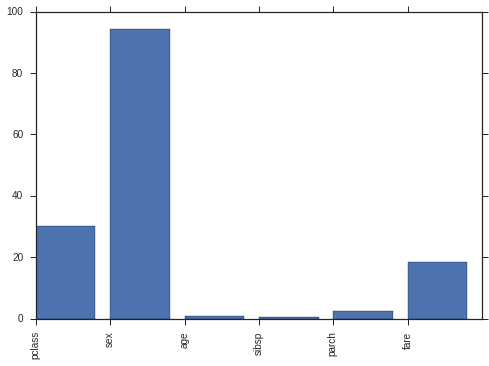

In [39]:
# selecting the best features

import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

#implement title into this prediction!!
predictors = ["pclass", "sex", "age", "sibsp", "parch", "fare"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic_full_new[predictors], titanic_full_new["survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the three best features.
predictors = ["pclass", "sex", "title", "fare"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

<u><h4 style="color:#6699FF">Support Vector Machines</h4></u>

In [40]:
y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

y = np.ravel(y)

from sklearn import svm
clf = svm.LinearSVC()
clf.fit(x,y)

clf2 = svm.SVC()
clf2.fit(x,y)

pred = clf.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)
print acc

0.737913486005


<u><h4 style="color:#6699FF">Naive Bayes</h4></u>

In [41]:
y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

y = np.ravel(y)

import numpy as np
import pylab as pl

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x, y)

pred = clf.predict(x_test)

from sklearn.metrics import accuracy_score
nb_acc = accuracy_score(pred, y_test)
print nb_acc


0.455470737913


<h2 style="color:#6699FF"> 6) Validation of Models</h2>This includes showing the following metrics about each model:
* **Logistic Regression**
    * Accuracy score
    * Statistical significance (p-value calculation)
    * Confusion Matrix
    * Cross validation 10 fold validation
* **Random Forests**
    * Best feature selection
    * Cross validation score
    * Feature importance scores -- indicating how influential each variable was in predicting outcome
        * includes measure of precision (measure of result relevance) and recall (sensitivity, how many results are relevant).
* **Support Vector Machines**
    * Accuracy score
* **Naive Bayes**
    * Accuracy score

<u><h4 style="color:#6699FF">Logistic Regression</h4></u>

In [42]:
# Accuracy Score

from patsy import dmatrices

y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

import numpy as np

# Flatten y into a 1-D array
y = np.ravel(y)

# Initiate a logistic regression model, and fit with X and y
LRmodel = LogisticRegression()
LRmodel = LRmodel.fit(x, y)

# Check the accuracy on the training set
LRmodel.score(x_test, y_test['survived'])

0.77099236641221369

In [43]:
# Logistic regression p-value determination using statsmodels

import statsmodels.api as sm
import numpy as np

a = titanic_full_new['survived']
b = titanic_full_new.drop('survived', axis=1).astype(int)

a1 = np.asarray(a)
b1 = np.asarray(b)

logit = sm.Logit(a1, b1)

print logit.fit_regularized().pvalues

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.435295003709
            Iterations: 112
            Function evaluations: 118
            Gradient evaluations: 112
[  1.20279093e-02   3.52588481e-04   4.90053717e-06   3.17356763e-02
   5.86803187e-15   3.02730470e-01   9.99999912e-01   9.99999976e-01
   9.99999951e-01   9.99999476e-01   9.99999429e-01   9.99998998e-01
   9.99999678e-01   9.99999651e-01   9.99999516e-01   9.99996344e-01]


In [44]:
# LR predicted confusion matrix

# Predict class labels
LRpredicted = LRmodel.predict(x_test)

print metrics.confusion_matrix(y_test, LRpredicted)
print metrics.classification_report(y_test, LRpredicted)

[[194  31]
 [ 59 109]]
             precision    recall  f1-score   support

        0.0       0.77      0.86      0.81       225
        1.0       0.78      0.65      0.71       168

avg / total       0.77      0.77      0.77       393



In [45]:
# Evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), x, y, scoring='accuracy', cv=10)
print scores
print scores.mean()

[ 0.84946237  0.75268817  0.79347826  0.85869565  0.81318681  0.84615385
  0.86813187  0.79120879  0.83516484  0.85714286]
0.826531346167


In [46]:
# Evaluation metrics
print metrics.accuracy_score(y_test, LRpredicted)
print metrics.roc_auc_score(y_test, LRprobs[:, 1])

0.770992366412
0.828677248677


In [47]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, LRpredicted)
print metrics.roc_auc_score(y_test, LRprobs[:, 1])

0.770992366412
0.828677248677


<u><h4 style="color:#6699FF">Random Forests</h4></u>

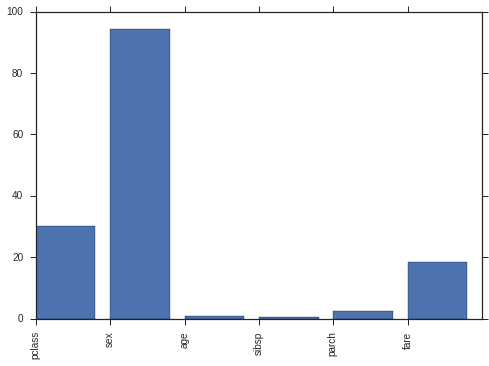

In [48]:
# selecting the best features in Random Forests

import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif

#implement title into this prediction!!
predictors = ["pclass", "sex", "age", "sibsp", "parch", "fare"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic_full_new[predictors], titanic_full_new["survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()

# Pick only the three best features.
predictors = ["pclass", "sex", "title", "fare"]

alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4)

In [49]:
# Cross Validation Scores of Random Forests

# basic random forests algorithim
# source: https://www.dataquest.io/mission/75/improving-your-submission/

from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
#put fare back in

predictors = ["pclass", "sex", "age", "sibsp", "parch", "fare", "C", "Q", "S", "Col", "Dr", "Master", "Miss", "Mr", "Mrs", "Rev"]

# n_estimators indicates 100 trees initially

alg = RandomForestClassifier(random_state=1, n_estimators=100, min_samples_split=2, min_samples_leaf=1)

scores = cross_validation.cross_val_score(alg, titanic_full_new[predictors], titanic_full_new["survived"], cv=3)

#nope below
#scores2 = cross_validation.cross_val_score(alg, titanic_train, titanic_test, cv=3)

print(scores.mean())

0.541737902978


In [50]:
# RF cross validation score after initializing RF alg function to improve parameters
alg = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(alg, titanic_full_new[predictors], titanic_full_new["survived"], cv=3)

print(scores.mean())

0.556241177657


In [51]:
# RF Feature Importance and Score
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

from patsy import dmatrices
import numpy as np

y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

# Flatten y into a 1-D array
y = np.ravel(y)

# Fit an Extra Trees model to the data
ETmodel = ExtraTreesClassifier()
ETmodel = ETmodel.fit(x, y)
print(ETmodel.feature_importances_)


# Table displaying feature importance scores
#print "%s %d" % (features[i], feature_importances_][i])
#for loop to loop through length x.columns. print x[i] 

print x.columns

ETmodel.score(x_test, y_test['survived'])

[ 0.          0.10474312  0.20390373  0.03941212  0.03445897  0.11702299
  0.21736255  0.0101086   0.00450523  0.00868925  0.0016732   0.00310691
  0.0092697   0.05728941  0.11879811  0.06351     0.00614611]
Index([u'Intercept', u'sex[T.1]', u'age', u'sibsp', u'parch', u'pclass',
       u'fare', u'C', u'Q', u'S', u'Col', u'Dr', u'Master', u'Miss', u'Mr',
       u'Mrs', u'Rev'],
      dtype='object')


0.74300254452926207

<u><h4 style="color:#6699FF">Support Vector Machines -- Accuracy Score</h4></u>

In [52]:
y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

y = np.ravel(y)

from sklearn import svm
clf = svm.LinearSVC()
clf.fit(x,y)

clf2 = svm.SVC()
clf2.fit(x,y)

pred = clf.predict(x_test)

from sklearn.metrics import accuracy_score
acc = accuracy_score(pred, y_test)
print acc
print "SVM accuracy score is " + str(acc)

0.704834605598
SVM accuracy score is 0.704834605598


<u><h4 style="color:#6699FF">Naive Bayes--Accuracy Score</h4></u>

In [53]:
y, x = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                 titanic_train, return_type="dataframe")

y_test, x_test = dmatrices('survived ~ sex + age + sibsp + parch + pclass + fare + + C + Q + S + Col + Dr + Master + Miss + Mr + Mrs + Rev',
                           titanic_test, return_type="dataframe")

y = np.ravel(y)

import numpy as np
import pylab as pl

from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(x, y)

pred = clf.predict(x_test)

from sklearn.metrics import accuracy_score
nb_acc = accuracy_score(pred, y_test)
print "Naive Bayes accuracy score is " + str(nb_acc)

Naive Bayes accuracy score is 0.455470737913


<font color="#6699FF"> &clubs; &hearts; &diams; &spades; </font>


<h2 style="color:#6699FF"> 7) Appendix</h2>

Sources of code, knowlege, and inspiration:

* Karen Xiao
* Spencer Allee
* Julian Modesto
* Norah (Yuan) Shi
* Nicholas Pascullo

* https://www.udacity.com/course/intro-to-machine-learning--ud120
* http://stanford.edu/~mwaskom/software/seaborn-dev/examples/factorplot_bars.html
* https://www.dataquest.io/mission/74/getting-started-with-kaggle/
* http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* https://www.dataquest.io/mission/75/improving-your-submission/
* https://www.kaggle.com/hekkon/titanic/testing
* https://www.kaggle.com/benhamner/titanic/python-seaborn-pairplot-example
* http://www.myhtmltutorials.com/font.html
* https://www.quora.com/Random-Forests/How-do-random-forests-work-in-laymans-terms
* http://stackoverflow.com/questions/11587782/creating-dummy-variables-in-pandas-for-python
* http://stackoverflow.com/questions/12207326/pandas-frequency-table-for-a-single-variable
* http://stackoverflow.com/questions/11587782/creating-dummy-variables-in-pandas-for-python



<h2 style="color:#6699FF"> 8) Appendix II</h2><br>
Things I would like to implement in the future: <p>
* **Further analysis of statistical significance of Logistic Regression model**
    * Information on parameter size (Starter code availble in v. 2.5)
    * Neatly displayed p-value table for comparison
    * Factor performance visualization
    * Confusion matrix gradient visualization (Starter code availble in v. 2.5)
   <br>
* **Further analysis and implementation of Random Forests**
    * Experiment with AdaBoost
    * Neatly display feature importance scores and include visualization of them
   <br>
* **Evaluate dummy variables more succinctly**
    * Condense them into less columns
   <br>
* **Include interesting variables**
    * Does cabin location distance from lifeboat have an effect?
* **Comparison of Algorithms**
    * Plot accuracy scores
   </p>